In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 37.6 MB/s eta 0:00:00


In [2]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/models_01.py --output models_01.py
!curl $URL_BASE/test_models_01.py --output test_models_01.py
!curl $URL_BASE/models_02.py --output models_02.py
!curl $URL_BASE/test_models_02.py --output test_models_02.py
!curl $URL_BASE/models_03.py --output models_03.py
!curl $URL_BASE/test_models_03.py --output test_models_03.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0   8327      0 --:--:-- --:--:-- --:--:--  8300
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   2133      0 --:--:-- --:--:-- --:--:--  2133
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6891  100  6891    0     0  21945      0 --:--:-- --:--:-- --:--:-- 21945
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2439  100  2439    0     0   7970      0 --:--:-- --:--:-- --:--:--  7944
  % Total    % Received % Xferd  Average Speed   Tim

In [3]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images
import torchmetrics

import matplotlib.pyplot as plt                       # Visualize images and more
import seaborn as sns
from tqdm import tqdm

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_01 import BrainNet_V3 as BrainNet_A_V3, BrainMobilenet
from models_02 import BrainNetv4 as BrainNet_B_V4, BrainGoogleNet
from models_03 import BrainNetv1R as BrainNet_C_V1, BrainResNet

# Preprocessing Dataset | (from .mat to .npy) 📥
Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [5]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in tqdm(range(3064)):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

100%|██████████| 3064/3064 [00:28<00:00, 107.23it/s]


save Labels

In [6]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

# Config Device and Seed 🖥 🎲

In [7]:
!nvidia-smi

Sun Jun 25 00:38:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Load Dataset and Create DataLoaders 💽

In [10]:
# Load Dataset
BATCH_SIZE = 16
EPOCHS = 20
HEADERS = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']

dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = plots.split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [11]:
# Split train_data for training and validation
train_set, val_set = plots.split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [12]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  115
Validation data:  39
Test data:  39


# Visualization of Dataset 👀

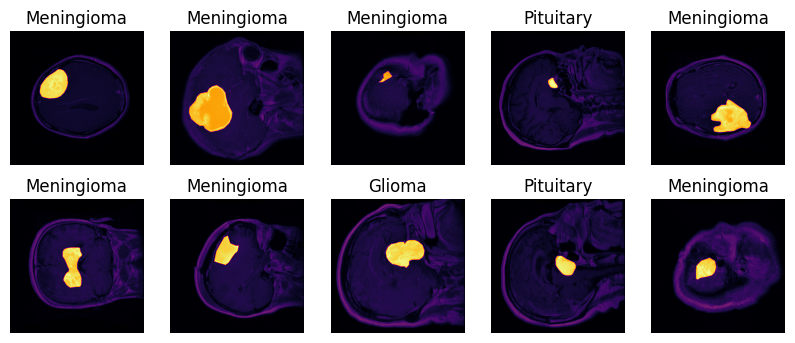

In [13]:
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()

  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(CLASS_NAMES[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

In [14]:
!python -m pytest test_models_01.py
!python -m pytest test_models_02.py
!python -m pytest test_models_03.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.2.0
rootdir: /content
plugins: anyio-3.7.0
collected 6 items                                                              

test_models_01.py ......                                                 [100%]

============================== 6 passed in 3.67s ===============================
============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.2.0
rootdir: /content
plugins: anyio-3.7.0
collected 5 items                                                              

test_models_02.py .....                                                  [100%]

============================== 5 passed in 3.55s ===============================
============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.2.0
rootdir: /

# Training 💪 🏋️

## BrainNet A V3 Lr(1e-3) Wr(1e-6)

In [15]:
model = BrainNet_A_V3()
brainnet_a_v3_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_a_v3_lr3_wr6_ckp = ModelCheckpoint('brainnet_a_v3_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_a_v3_lr3_wr6_ckp)

brainnet_a_v3_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:19, train_loss=0.550, train_acc=0.788, train_f1=0.777, val_loss=0.266, val_acc=0.905, val_f1=0.908, lr=0.001


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:12, train_loss=0.296, train_acc=0.900, train_f1=0.900, val_loss=1.814, val_acc=0.638, val_f1=0.545, lr=0.001


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:11, train_loss=0.276, train_acc=0.909, train_f1=0.908, val_loss=0.252, val_acc=0.890, val_f1=0.895, lr=0.001


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:11, train_loss=0.229, train_acc=0.916, train_f1=0.916, val_loss=0.358, val_acc=0.867, val_f1=0.872, lr=0.001


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:11, train_loss=0.168, train_acc=0.941, train_f1=0.941, val_loss=0.201, val_acc=0.936, val_f1=0.935, lr=0.001


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:11, train_loss=0.169, train_acc=0.950, train_f1=0.950, val_loss=0.107, val_acc=0.961, val_f1=0.961, lr=0.001


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:12, train_loss=0.162, train_acc=0.949, train_f1=0.949, val_loss=0.234, val_acc=0.921, val_f1=0.924, lr=0.001


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:11, train_loss=0.130, train_acc=0.959, train_f1=0.959, val_loss=0.061, val_acc=0.977, val_f1=0.977, lr=0.001


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:12, train_loss=0.092, train_acc=0.972, train_f1=0.972, val_loss=0.067, val_acc=0.970, val_f1=0.971, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:12, train_loss=0.091, train_acc=0.968, train_f1=0.968, val_loss=0.099, val_acc=0.954, val_f1=0.955, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:12, train_loss=0.055, train_acc=0.984, train_f1=0.984, val_loss=0.112, val_acc=0.956, val_f1=0.954, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:12, train_loss=0.042, train_acc=0.991, train_f1=0.991, val_loss=0.040, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:12, train_loss=0.052, train_acc=0.984, train_f1=0.984, val_loss=0.040, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:12, train_loss=0.038, train_acc=0.986, train_f1=0.986, val_loss=0.045, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:12, train_loss=0.030, train_acc=0.992, train_f1=0.992, val_loss=0.045, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:12, train_loss=0.033, train_acc=0.988, train_f1=0.988, val_loss=0.035, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:12, train_loss=0.030, train_acc=0.991, train_f1=0.991, val_loss=0.037, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:12, train_loss=0.034, train_acc=0.987, train_f1=0.987, val_loss=0.058, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:12, train_loss=0.040, train_acc=0.988, train_f1=0.988, val_loss=0.071, val_acc=0.975, val_f1=0.976, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:12, train_loss=0.049, train_acc=0.984, train_f1=0.984, val_loss=0.068, val_acc=0.974, val_f1=0.974, lr=0.000


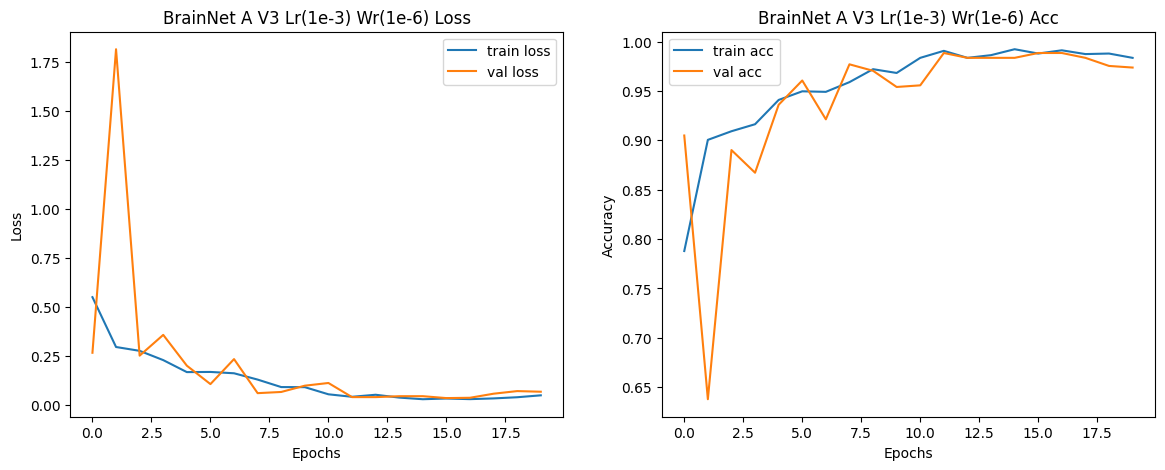

In [16]:
plots.plot_model_results("BrainNet A V3 Lr(1e-3) Wr(1e-6)", brainnet_a_v3_lr3_wr6_results)

In [17]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
])

+---------------------------------+------------+----------+-----------+---------+----------+
|              Model              | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+---------------------------------+------------+----------+-----------+---------+----------+
| BrainNet A V3 Lr(1e-3) Wr(1e-6) |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
+---------------------------------+------------+----------+-----------+---------+----------+


# BrainMobilenet lr4 wr8

In [18]:
model = BrainMobilenet()
brainmobilenet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-6, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainmobilenet_lr4_wr8_ckp = ModelCheckpoint('brainmobilenet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainmobilenet_lr4_wr8_ckp, three_channels=True)

brainmobilenet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:16, train_loss=1.004, train_acc=0.520, train_f1=0.484, val_loss=0.844, val_acc=0.715, val_f1=0.622, lr=0.000


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:15, train_loss=0.787, train_acc=0.687, train_f1=0.648, val_loss=0.626, val_acc=0.767, val_f1=0.701, lr=0.000


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:15, train_loss=0.550, train_acc=0.794, train_f1=0.774, val_loss=0.390, val_acc=0.884, val_f1=0.885, lr=0.000


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:15, train_loss=0.363, train_acc=0.872, train_f1=0.870, val_loss=0.253, val_acc=0.908, val_f1=0.910, lr=0.000


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:15, train_loss=0.228, train_acc=0.927, train_f1=0.927, val_loss=0.154, val_acc=0.944, val_f1=0.945, lr=0.000


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:15, train_loss=0.146, train_acc=0.949, train_f1=0.949, val_loss=0.098, val_acc=0.961, val_f1=0.961, lr=0.000


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:15, train_loss=0.108, train_acc=0.969, train_f1=0.969, val_loss=0.073, val_acc=0.970, val_f1=0.970, lr=0.000


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:15, train_loss=0.066, train_acc=0.980, train_f1=0.980, val_loss=0.069, val_acc=0.975, val_f1=0.975, lr=0.000


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:15, train_loss=0.041, train_acc=0.990, train_f1=0.990, val_loss=0.064, val_acc=0.975, val_f1=0.975, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:15, train_loss=0.025, train_acc=0.996, train_f1=0.996, val_loss=0.042, val_acc=0.982, val_f1=0.982, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:15, train_loss=0.028, train_acc=0.993, train_f1=0.993, val_loss=0.100, val_acc=0.966, val_f1=0.966, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:15, train_loss=0.037, train_acc=0.991, train_f1=0.991, val_loss=0.065, val_acc=0.970, val_f1=0.970, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:15, train_loss=0.046, train_acc=0.985, train_f1=0.985, val_loss=0.054, val_acc=0.980, val_f1=0.980, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:15, train_loss=0.020, train_acc=0.996, train_f1=0.996, val_loss=0.037, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:15, train_loss=0.011, train_acc=0.998, train_f1=0.998, val_loss=0.068, val_acc=0.975, val_f1=0.976, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:15, train_loss=0.008, train_acc=0.998, train_f1=0.998, val_loss=0.039, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:15, train_loss=0.004, train_acc=1.000, train_f1=1.000, val_loss=0.025, val_acc=0.992, val_f1=0.992, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:15, train_loss=0.004, train_acc=1.000, train_f1=1.000, val_loss=0.018, val_acc=0.993, val_f1=0.993, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:15, train_loss=0.003, train_acc=0.999, train_f1=0.999, val_loss=0.034, val_acc=0.985, val_f1=0.985, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:15, train_loss=0.005, train_acc=0.999, train_f1=0.999, val_loss=0.049, val_acc=0.985, val_f1=0.985, lr=0.000


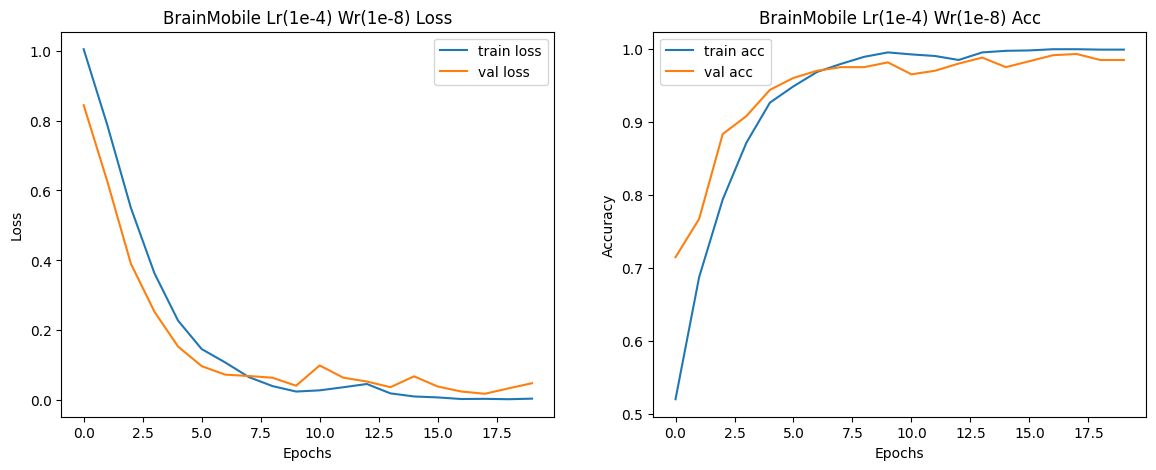

In [19]:
plots.plot_model_results("BrainMobile Lr(1e-4) Wr(1e-8)", brainmobilenet_lr4_wr8_results)

In [20]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params]
])

+---------------------------------+------------+----------+-----------+---------+----------+
|              Model              | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+---------------------------------+------------+----------+-----------+---------+----------+
| BrainNet A V3 Lr(1e-3) Wr(1e-6) |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
|  BrainMobile Lr(1e-4) Wr(1e-8)  |   0.004    |  0.018   |   1.000   |  0.993  | 2227715  |
+---------------------------------+------------+----------+-----------+---------+----------+


## Brainet B V4

In [21]:
model = BrainNet_B_V4()
brainnet_b_v4_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_b_v4_lr3_wr6_ckp = ModelCheckpoint('brainnet_b_v4_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_b_v4_lr3_wr6_ckp)

brainnet_b_v4_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:11, train_loss=0.441, train_acc=0.826, train_f1=0.823, val_loss=0.826, val_acc=0.662, val_f1=0.582, lr=0.001


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:11, train_loss=0.251, train_acc=0.910, train_f1=0.909, val_loss=0.171, val_acc=0.941, val_f1=0.941, lr=0.001


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:11, train_loss=0.219, train_acc=0.918, train_f1=0.917, val_loss=0.430, val_acc=0.838, val_f1=0.842, lr=0.001


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:11, train_loss=0.161, train_acc=0.949, train_f1=0.948, val_loss=0.087, val_acc=0.979, val_f1=0.979, lr=0.001


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:11, train_loss=0.143, train_acc=0.952, train_f1=0.952, val_loss=0.270, val_acc=0.915, val_f1=0.916, lr=0.001


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:11, train_loss=0.171, train_acc=0.937, train_f1=0.937, val_loss=1.226, val_acc=0.600, val_f1=0.511, lr=0.001


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:11, train_loss=0.111, train_acc=0.959, train_f1=0.959, val_loss=0.114, val_acc=0.956, val_f1=0.955, lr=0.001


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:11, train_loss=0.081, train_acc=0.971, train_f1=0.971, val_loss=0.122, val_acc=0.966, val_f1=0.966, lr=0.001


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:11, train_loss=0.059, train_acc=0.982, train_f1=0.982, val_loss=0.069, val_acc=0.979, val_f1=0.979, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:11, train_loss=0.050, train_acc=0.983, train_f1=0.982, val_loss=0.215, val_acc=0.939, val_f1=0.940, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:11, train_loss=0.034, train_acc=0.989, train_f1=0.989, val_loss=0.431, val_acc=0.895, val_f1=0.885, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:11, train_loss=0.032, train_acc=0.989, train_f1=0.989, val_loss=0.106, val_acc=0.956, val_f1=0.955, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:11, train_loss=0.039, train_acc=0.985, train_f1=0.985, val_loss=0.265, val_acc=0.921, val_f1=0.916, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:11, train_loss=0.024, train_acc=0.992, train_f1=0.992, val_loss=0.139, val_acc=0.956, val_f1=0.957, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:11, train_loss=0.016, train_acc=0.996, train_f1=0.996, val_loss=0.048, val_acc=0.982, val_f1=0.982, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:11, train_loss=0.016, train_acc=0.996, train_f1=0.996, val_loss=0.037, val_acc=0.992, val_f1=0.992, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:11, train_loss=0.014, train_acc=0.997, train_f1=0.997, val_loss=0.043, val_acc=0.980, val_f1=0.980, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:11, train_loss=0.016, train_acc=0.996, train_f1=0.996, val_loss=0.043, val_acc=0.989, val_f1=0.988, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:11, train_loss=0.017, train_acc=0.996, train_f1=0.996, val_loss=0.170, val_acc=0.952, val_f1=0.951, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:11, train_loss=0.019, train_acc=0.993, train_f1=0.993, val_loss=0.228, val_acc=0.938, val_f1=0.937, lr=0.000


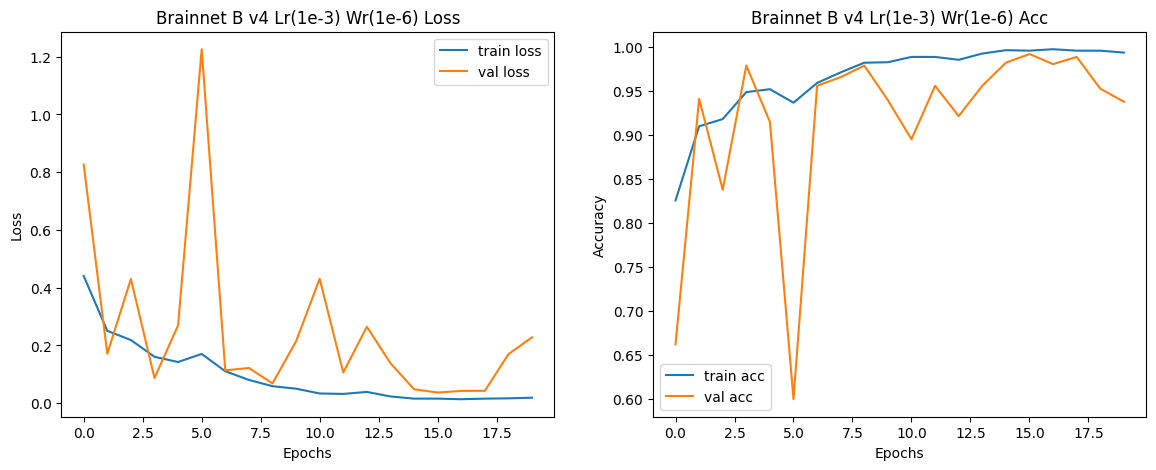

In [22]:
plots.plot_model_results("Brainnet B v4 Lr(1e-3) Wr(1e-6)", brainnet_b_v4_lr3_wr6_results)

In [23]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params]
])

+---------------------------------+------------+----------+-----------+---------+----------+
|              Model              | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+---------------------------------+------------+----------+-----------+---------+----------+
| BrainNet A V3 Lr(1e-3) Wr(1e-6) |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
|  BrainMobile Lr(1e-4) Wr(1e-8)  |   0.004    |  0.018   |   1.000   |  0.993  | 2227715  |
| Brainnet B v4 Lr(1e-3) Wr(1e-6) |   0.016    |  0.037   |   0.996   |  0.992  |  403987  |
+---------------------------------+------------+----------+-----------+---------+----------+


## Brainet GoogleNet

In [24]:
model = BrainGoogleNet()
brainet_googlenet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-5)

brainet_googlenet_lr4_wr8_ckp = ModelCheckpoint('brainnet_googlenet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainet_googlenet_lr4_wr8_ckp, three_channels=True)

brainet_googlenet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:14, train_loss=0.322, train_acc=0.885, train_f1=0.885, val_loss=0.722, val_acc=0.705, val_f1=0.627, lr=0.001


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:13, train_loss=0.177, train_acc=0.935, train_f1=0.935, val_loss=0.430, val_acc=0.859, val_f1=0.863, lr=0.001


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:13, train_loss=0.110, train_acc=0.962, train_f1=0.962, val_loss=0.238, val_acc=0.908, val_f1=0.907, lr=0.001


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:13, train_loss=0.126, train_acc=0.960, train_f1=0.959, val_loss=0.342, val_acc=0.870, val_f1=0.872, lr=0.001


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:13, train_loss=0.091, train_acc=0.973, train_f1=0.973, val_loss=0.630, val_acc=0.785, val_f1=0.793, lr=0.001


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:13, train_loss=0.069, train_acc=0.980, train_f1=0.980, val_loss=0.215, val_acc=0.921, val_f1=0.922, lr=0.001


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:13, train_loss=0.042, train_acc=0.989, train_f1=0.989, val_loss=0.983, val_acc=0.726, val_f1=0.639, lr=0.001


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:13, train_loss=0.036, train_acc=0.989, train_f1=0.989, val_loss=0.059, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:13, train_loss=0.032, train_acc=0.990, train_f1=0.990, val_loss=0.139, val_acc=0.959, val_f1=0.959, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:14, train_loss=0.016, train_acc=0.997, train_f1=0.997, val_loss=0.080, val_acc=0.966, val_f1=0.966, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:14, train_loss=0.010, train_acc=0.998, train_f1=0.998, val_loss=0.046, val_acc=0.982, val_f1=0.982, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:14, train_loss=0.009, train_acc=0.999, train_f1=0.999, val_loss=0.032, val_acc=0.990, val_f1=0.990, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:14, train_loss=0.007, train_acc=0.999, train_f1=0.999, val_loss=0.036, val_acc=0.987, val_f1=0.987, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:13, train_loss=0.007, train_acc=0.998, train_f1=0.998, val_loss=0.035, val_acc=0.987, val_f1=0.987, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:14, train_loss=0.004, train_acc=1.000, train_f1=1.000, val_loss=0.029, val_acc=0.987, val_f1=0.987, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:13, train_loss=0.005, train_acc=0.999, train_f1=0.999, val_loss=0.031, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:14, train_loss=0.004, train_acc=1.000, train_f1=1.000, val_loss=0.028, val_acc=0.992, val_f1=0.992, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:14, train_loss=0.008, train_acc=0.998, train_f1=0.998, val_loss=0.032, val_acc=0.985, val_f1=0.985, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:14, train_loss=0.003, train_acc=1.000, train_f1=1.000, val_loss=0.035, val_acc=0.984, val_f1=0.984, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:14, train_loss=0.004, train_acc=0.999, train_f1=0.999, val_loss=0.060, val_acc=0.977, val_f1=0.977, lr=0.000


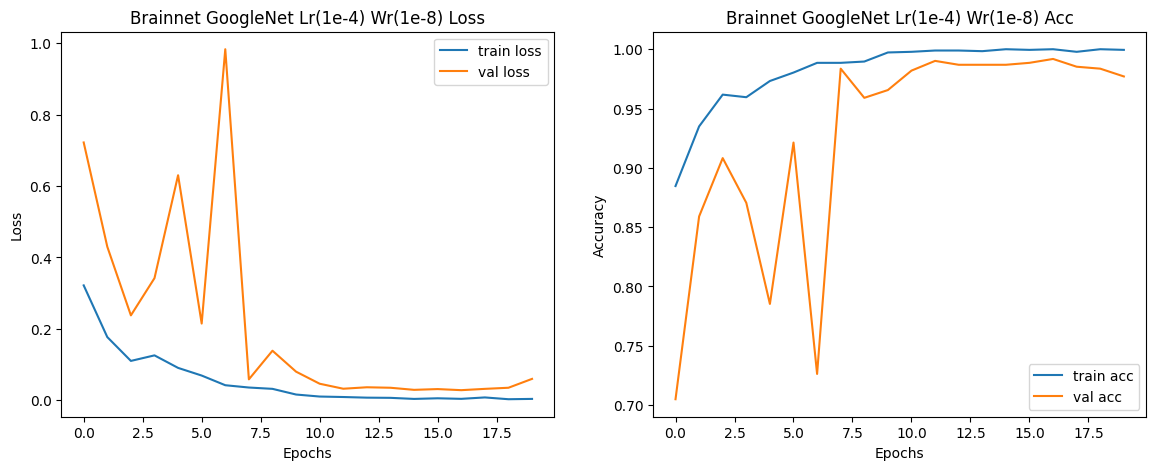

In [25]:
plots.plot_model_results("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)", brainet_googlenet_lr4_wr8_results)

In [26]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params]
])

+--------------------------------------+------------+----------+-----------+---------+----------+
|                Model                 | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+--------------------------------------+------------+----------+-----------+---------+----------+
|   BrainNet A V3 Lr(1e-3) Wr(1e-6)    |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
|    BrainMobile Lr(1e-4) Wr(1e-8)     |   0.004    |  0.018   |   1.000   |  0.993  | 2227715  |
|   Brainnet B v4 Lr(1e-3) Wr(1e-6)    |   0.016    |  0.037   |   0.996   |  0.992  |  403987  |
| Brainnet GoogleNet Lr(1e-4) Wr(1e-8) |   0.004    |  0.028   |   1.000   |  0.992  | 5602979  |
+--------------------------------------+------------+----------+-----------+---------+----------+


## BrainNet C V1

In [27]:
model = BrainNet_C_V1()
brainnet_c_v1_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_c_v1_lr3_wr6_ckp = ModelCheckpoint('brainnet_c_v1_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_c_v1_lr3_wr6_ckp)

brainnet_c_v1_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:10, train_loss=0.484, train_acc=0.800, train_f1=0.797, val_loss=0.870, val_acc=0.751, val_f1=0.663, lr=0.001


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:10, train_loss=0.260, train_acc=0.911, train_f1=0.911, val_loss=1.185, val_acc=0.680, val_f1=0.679, lr=0.001


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:10, train_loss=0.176, train_acc=0.937, train_f1=0.937, val_loss=1.034, val_acc=0.661, val_f1=0.684, lr=0.001


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:10, train_loss=0.187, train_acc=0.937, train_f1=0.937, val_loss=0.247, val_acc=0.907, val_f1=0.910, lr=0.001


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:10, train_loss=0.175, train_acc=0.937, train_f1=0.937, val_loss=0.142, val_acc=0.941, val_f1=0.940, lr=0.001


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:10, train_loss=0.107, train_acc=0.966, train_f1=0.966, val_loss=0.487, val_acc=0.861, val_f1=0.853, lr=0.001


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:10, train_loss=0.153, train_acc=0.948, train_f1=0.947, val_loss=8.458, val_acc=0.252, val_f1=0.102, lr=0.001


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:10, train_loss=0.110, train_acc=0.961, train_f1=0.961, val_loss=0.116, val_acc=0.957, val_f1=0.957, lr=0.001


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:10, train_loss=0.081, train_acc=0.973, train_f1=0.973, val_loss=0.184, val_acc=0.918, val_f1=0.918, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:10, train_loss=0.067, train_acc=0.980, train_f1=0.980, val_loss=0.054, val_acc=0.980, val_f1=0.980, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:10, train_loss=0.060, train_acc=0.980, train_f1=0.980, val_loss=0.478, val_acc=0.846, val_f1=0.856, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:10, train_loss=0.044, train_acc=0.986, train_f1=0.986, val_loss=0.041, val_acc=0.987, val_f1=0.987, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:10, train_loss=0.026, train_acc=0.993, train_f1=0.993, val_loss=0.052, val_acc=0.977, val_f1=0.977, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:10, train_loss=0.022, train_acc=0.993, train_f1=0.993, val_loss=0.035, val_acc=0.985, val_f1=0.985, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:10, train_loss=0.016, train_acc=0.996, train_f1=0.996, val_loss=0.034, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:10, train_loss=0.011, train_acc=0.996, train_f1=0.996, val_loss=0.043, val_acc=0.987, val_f1=0.987, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:10, train_loss=0.019, train_acc=0.993, train_f1=0.993, val_loss=0.063, val_acc=0.975, val_f1=0.975, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:10, train_loss=0.017, train_acc=0.995, train_f1=0.995, val_loss=0.040, val_acc=0.989, val_f1=0.989, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:10, train_loss=0.023, train_acc=0.992, train_f1=0.992, val_loss=0.121, val_acc=0.959, val_f1=0.959, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:10, train_loss=0.022, train_acc=0.992, train_f1=0.992, val_loss=0.118, val_acc=0.959, val_f1=0.960, lr=0.000


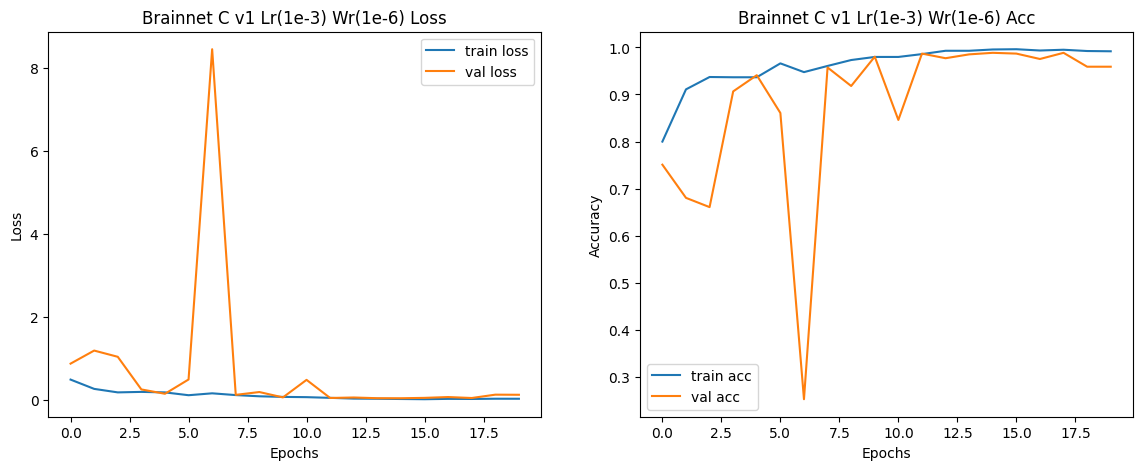

In [28]:
plots.plot_model_results("Brainnet C v1 Lr(1e-3) Wr(1e-6)", brainnet_c_v1_lr3_wr6_results)

In [29]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params],
plots.row("Brainnet C v1 Lr(1e-3) Wr(1e-6)",brainnet_c_v1_lr3_wr6_ckp.best_results)+[brainnet_c_v1_lr3_wr6_num_params]
])

+--------------------------------------+------------+----------+-----------+---------+----------+
|                Model                 | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+--------------------------------------+------------+----------+-----------+---------+----------+
|   BrainNet A V3 Lr(1e-3) Wr(1e-6)    |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
|    BrainMobile Lr(1e-4) Wr(1e-8)     |   0.004    |  0.018   |   1.000   |  0.993  | 2227715  |
|   Brainnet B v4 Lr(1e-3) Wr(1e-6)    |   0.016    |  0.037   |   0.996   |  0.992  |  403987  |
| Brainnet GoogleNet Lr(1e-4) Wr(1e-8) |   0.004    |  0.028   |   1.000   |  0.992  | 5602979  |
|   Brainnet C v1 Lr(1e-3) Wr(1e-6)    |   0.016    |  0.034   |   0.996   |  0.989  |  413047  |
+--------------------------------------+------------+----------+-----------+---------+----------+


## BrainNet Resnet

In [30]:
model = BrainResNet()
BrainResNet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

BrainResNet_lr4_wr8_ckp = ModelCheckpoint('BrainResNet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(BrainResNet_lr4_wr8_ckp, three_channels=True)
brainresnet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (1/20): time=00:20, train_loss=0.444, train_acc=0.821, train_f1=0.820, val_loss=3.201, val_acc=0.438, val_f1=0.392, lr=0.001


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (2/20): time=00:19, train_loss=0.278, train_acc=0.892, train_f1=0.891, val_loss=0.723, val_acc=0.731, val_f1=0.705, lr=0.001


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (3/20): time=00:20, train_loss=0.209, train_acc=0.929, train_f1=0.929, val_loss=0.764, val_acc=0.770, val_f1=0.754, lr=0.001


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (4/20): time=00:19, train_loss=0.172, train_acc=0.939, train_f1=0.939, val_loss=1.152, val_acc=0.764, val_f1=0.700, lr=0.001


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (5/20): time=00:20, train_loss=0.175, train_acc=0.938, train_f1=0.937, val_loss=2.104, val_acc=0.636, val_f1=0.573, lr=0.001


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (6/20): time=00:19, train_loss=0.265, train_acc=0.896, train_f1=0.895, val_loss=8.411, val_acc=0.482, val_f1=0.440, lr=0.001


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (7/20): time=00:19, train_loss=0.172, train_acc=0.946, train_f1=0.946, val_loss=5.008, val_acc=0.307, val_f1=0.205, lr=0.001


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (8/20): time=00:19, train_loss=0.115, train_acc=0.955, train_f1=0.955, val_loss=4.232, val_acc=0.477, val_f1=0.442, lr=0.001


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (9/20): time=00:20, train_loss=0.083, train_acc=0.974, train_f1=0.974, val_loss=0.155, val_acc=0.933, val_f1=0.933, lr=0.000


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (10/20): time=00:20, train_loss=0.052, train_acc=0.983, train_f1=0.983, val_loss=0.083, val_acc=0.970, val_f1=0.970, lr=0.000


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (11/20): time=00:19, train_loss=0.062, train_acc=0.979, train_f1=0.979, val_loss=13.275, val_acc=0.267, val_f1=0.132, lr=0.000


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (12/20): time=00:20, train_loss=0.062, train_acc=0.980, train_f1=0.980, val_loss=0.203, val_acc=0.920, val_f1=0.922, lr=0.000


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (13/20): time=00:19, train_loss=0.041, train_acc=0.991, train_f1=0.991, val_loss=1.223, val_acc=0.721, val_f1=0.729, lr=0.000


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (14/20): time=00:20, train_loss=0.016, train_acc=0.997, train_f1=0.997, val_loss=0.066, val_acc=0.979, val_f1=0.979, lr=0.000


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (15/20): time=00:20, train_loss=0.019, train_acc=0.996, train_f1=0.996, val_loss=0.082, val_acc=0.974, val_f1=0.974, lr=0.000


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (16/20): time=00:20, train_loss=0.017, train_acc=0.996, train_f1=0.996, val_loss=0.179, val_acc=0.949, val_f1=0.950, lr=0.000


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (17/20): time=00:19, train_loss=0.010, train_acc=0.999, train_f1=0.999, val_loss=0.071, val_acc=0.975, val_f1=0.975, lr=0.000


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (18/20): time=00:20, train_loss=0.011, train_acc=0.998, train_f1=0.998, val_loss=0.069, val_acc=0.980, val_f1=0.980, lr=0.000


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (19/20): time=00:20, train_loss=0.009, train_acc=0.998, train_f1=0.998, val_loss=0.422, val_acc=0.852, val_f1=0.843, lr=0.000


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch (20/20): time=00:20, train_loss=0.047, train_acc=0.984, train_f1=0.984, val_loss=0.108, val_acc=0.964, val_f1=0.964, lr=0.000


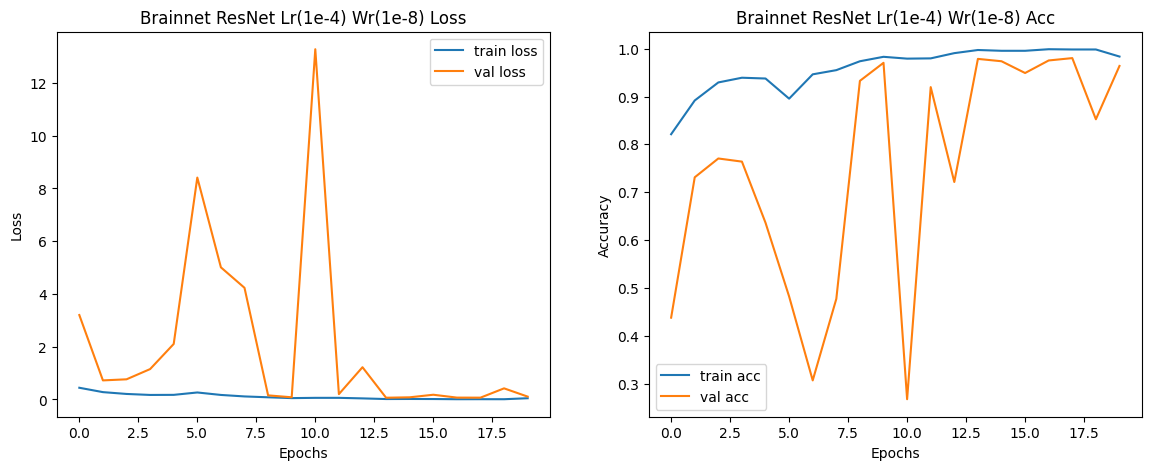

In [31]:
plots.plot_model_results("Brainnet ResNet Lr(1e-4) Wr(1e-8)", brainresnet_lr4_wr8_results)

In [32]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params],
plots.row("Brainnet C v1 Lr(1e-3) Wr(1e-6)",brainnet_c_v1_lr3_wr6_ckp.best_results)+[brainnet_c_v1_lr3_wr6_num_params],
plots.row("Brainnet ResNet Lr(1e-4) Wr(1e-8)",BrainResNet_lr4_wr8_ckp.best_results)+[BrainResNet_lr4_wr8_num_params]
])

+--------------------------------------+------------+----------+-----------+---------+----------+
|                Model                 | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+--------------------------------------+------------+----------+-----------+---------+----------+
|   BrainNet A V3 Lr(1e-3) Wr(1e-6)    |   0.033    |  0.035   |   0.988   |  0.989  |  427339  |
|    BrainMobile Lr(1e-4) Wr(1e-8)     |   0.004    |  0.018   |   1.000   |  0.993  | 2227715  |
|   Brainnet B v4 Lr(1e-3) Wr(1e-6)    |   0.016    |  0.037   |   0.996   |  0.992  |  403987  |
| Brainnet GoogleNet Lr(1e-4) Wr(1e-8) |   0.004    |  0.028   |   1.000   |  0.992  | 5602979  |
|   Brainnet C v1 Lr(1e-3) Wr(1e-6)    |   0.016    |  0.034   |   0.996   |  0.989  |  413047  |
|  Brainnet ResNet Lr(1e-4) Wr(1e-8)   |   0.016    |  0.066   |   0.997   |  0.979  | 23514179 |
+--------------------------------------+------------+----------+-----------+---------+----------+


# Best Model

In [33]:
best_model = BrainMobilenet()
best_model = best_model.to(device)
brainmobilenet_lr4_wr8_ckp.load_checkpoint(best_model)

In [34]:
loss_fn = nn.CrossEntropyLoss()
test_results = trainer.test_phase(test_dl, best_model, loss_fn, device)

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

In [35]:
print(f'\nTest loss: {test_results["loss"]:.3f}')
print(f'Test accuracy: {test_results["acc"]:.3f}')
print(f'Test f1-score: {test_results["f1"]:.3f}')


Test loss: 0.041
Test accuracy: 0.985
Test f1-score: 0.985


In [36]:
def predict_labels(model, test_dl):
  y_pred = []
  y_true = []

  model.eval()

  with torch.no_grad():
    for X, y in test_dl:
      X = torch.concat([X, X.mean(1, keepdim=True)], 1)
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      y_pred.append(logits.detach().to('cpu'))
      y_true.append(y.detach().to('cpu'))
  return torch.concat(y_pred), torch.concat(y_true)

In [37]:
y_test_pred, y_test_true = predict_labels(best_model, test_dl)

In [38]:
print(f"Predictions size: {y_test_pred.size()}")
print(f"True Labels size: {y_test_true.size()}")

Predictions size: torch.Size([610, 3])
True Labels size: torch.Size([610])


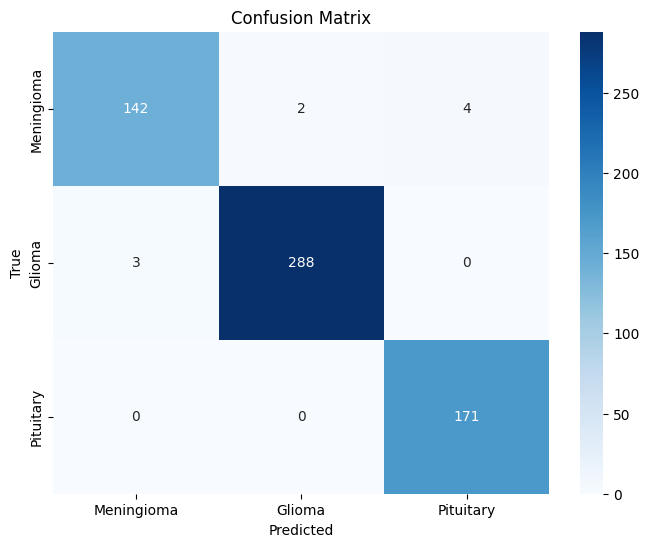

In [39]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
  confusion_matrix = torchmetrics.ConfusionMatrix('multiclass', num_classes=3)
  confusion_matrix = confusion_matrix.to('cpu')
  cm = confusion_matrix(predicted_labels, true_labels).to('cpu')

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
plot_confusion_matrix(y_test_true, y_test_pred, CLASS_NAMES)